# Train a RESNET model on the esc50 dataset

## Imports

In [1]:
# change working directory to the root of the project
import os
os.chdir("../")
print("Current working directory: {0}".format(os.getcwd()))

Current working directory: /workspaces/GADME


In [2]:
# imports
from omegaconf import OmegaConf
import torchvision
import torch
import torchmetrics.classification

from src.modules.base_module import BaseModule
from src.datamodule.esc50_datamodule import ESC50
from src.utils.ast_extractor import CustomASTFeatureExtractor


## Datamodule

In [3]:
esc50_config = OmegaConf.create({
    "dataset": {
        "data_dir": "/workspaces/GADME/data",
        "dataset_name": "esc50",
        "hf_path": "ashraq/esc50",
        "hf_name": None,
        "seed": 42,
        "feature_extractor": {
            "_target_": 'src.utils.ast_extractor.CustomASTFeatureExtractor',
            "n_classes": 50,
            "n_workers": 1,
            "column_list": ["input_values", "target"],
            "sampling_rate": 32000,
            "return_tensor": 'pt',
        },
        "n_classes": 50,
        "n_workers": 16,
        "column_list": ["input_values", "target"],
        "val_split": 0.2,
    },
    "loaders": {
        "train": {
            "batch_size": 64,
            "shuffle": True,
            "num_workers": 32,
            "drop_last": False,
            "pin_memory": False
        },
        "valid": {
            "batch_size": 64,
            "shuffle": False,
            "num_workers": 32,
            "drop_last": False,
            "pin_memory": False
        },
        "test": {
            "batch_size": 6,
            "shuffle": False,
            "num_workers": 4,
            "drop_last": False,
            "pin_memory": False
        },
    },
    "transforms": {
        "use_channel_dim": True,
        "normalize": True,
        "use_spectrogram": True,
        "n_fft": 1024,
        "hop_length": 79,
        "n_mels": 128,
        "db_scale": True,
        "target_height": 32,
        "target_width": 32,
        "waveform_augmentations": {
            "colored_noise": {
                "prob": 0.5,
                "min_snr_in_db": 3.0,
                "max_snr_in_db": 30.0,
                "min_f_decay": -2.0,
                "max_f_decay": 2.0
            },
        },
        "spectrogram_augmentations": {
            "time_masking": {
                "time_mask_param": 100,
                "prob": 0.5
            },
            "frequency_masking": {
                "freq_mask_param": 100,
                "prob": 0.5
            },
            "time_stretch": {
                "prob": 0.5,
                "min_rate": 0.8,
                "max_rate": 1.2
            },
        },
    },
})

In [4]:
esc50_datamodule = ESC50(dataset=esc50_config.dataset, loaders=esc50_config.loaders, transforms=esc50_config.transforms)

In [27]:
esc50_datamodule.prepare_data()

Repo card metadata block was not found. Setting CardData to empty.


Map (num_proc=16):   0%|          | 0/2000 [00:00<?, ? examples/s]

Saving the dataset (0/3 shards):   0%|          | 0/1600 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/200 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/200 [00:00<?, ? examples/s]

In [28]:
esc50_datamodule.setup(stage="fit") 

In [21]:
train_dataloader = esc50_datamodule.train_dataloader()
batch = next(iter(train_dataloader))

In [22]:
batch

{'input_values': tensor([[[[-8.8381e-01, -1.4403e+00, -2.0807e-03,  ...,  1.3756e+00,
             9.5521e-01,  4.6009e-01],
           [-2.9873e-01, -8.5521e-01,  5.8300e-01,  ...,  1.9606e+00,
             1.5403e+00,  1.0452e+00],
           [ 1.7588e+00,  1.8201e+00,  1.9262e+00,  ...,  2.1592e+00,
             2.0430e+00,  1.9352e+00],
           ...,
           [-3.4712e-01,  4.2145e-01,  1.0251e+00,  ...,  6.1928e-02,
             3.9102e-01,  6.0605e-01],
           [ 7.3823e-01,  8.5905e-01,  1.0857e+00,  ...,  2.8951e-01,
             3.4515e-01,  3.7695e-01],
           [ 3.9075e-01,  4.9374e-01,  6.3433e-01,  ...,  2.2800e-01,
             8.2780e-02, -1.1711e-01]]],
 
 
         [[[-2.5118e+00, -2.5419e+00, -2.5900e+00,  ..., -3.9896e+00,
            -3.8270e+00, -3.5008e+00],
           [-1.9267e+00, -1.9568e+00, -2.0049e+00,  ..., -3.4046e+00,
            -3.2419e+00, -2.9158e+00],
           [-1.9659e+00, -2.0984e+00, -2.3249e+00,  ..., -2.3808e+00,
            -2.2738e

In [23]:
batch['input_values'].shape

torch.Size([128, 1, 32, 32])

In [49]:
batch['labels'].shape

torch.Size([6])

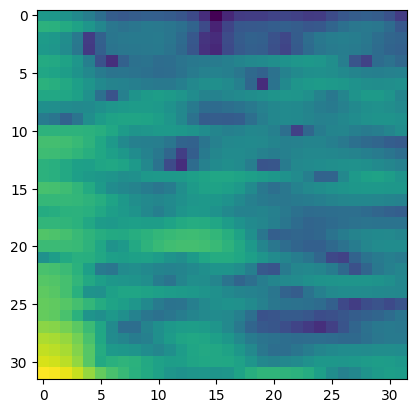

In [51]:
# plot the first spectrogram
import matplotlib.pyplot as plt
plt.imshow(batch['input_values'][2].squeeze().numpy())


## Lightning Module

In [29]:
len_trainset = len(esc50_datamodule.train_dataset)
module_config = OmegaConf.create({
    "network": {
        "model_name": "resnet50",
        "model": {
            "_target_": 'src.modules.models.resnet.ResNetClassifier',
            "baseline_architecture": 'resnet18',
            "num_classes": 50,
            "num_channels": 1,
            "pretrained": True,
        },
        "torch_compile": False
    },
    "output_activation": {
        "_target_": 'torch.softmax',
        "dim": 1
    },
    "loss": {
        "_target_": 'torch.nn.CrossEntropyLoss'
    },
    "optimizer": {
        "_target_": 'torch.optim.Adam',
        "lr": 0.001,
        "weight_decay": 0.01
    },
    "lr_scheduler": {
        "_target_": 'torch.optim.lr_scheduler',
    },
    "metrics": {
        "main": {
            "_target_": 'torchmetrics.classification.Accuracy',
            "task": "multiclass",
            "num_classes": 50,
            "top_k": 1,
        },
        "val_best": {   
            "_target_": 'torchmetrics.MaxMetric',
        }
    },
    "num_epochs": 200,
    "logging_params": {
        "on_step": False,
        "on_epoch": True,
        "sync_dist": False,
        "prog_bar": True,
    },
    "len_trainset": len_trainset
})

In [30]:
resnetModule = BaseModule(
    network=module_config.network,
    output_activation= module_config.output_activation,
    loss=module_config.loss,
    optimizer=module_config.optimizer,
    lr_scheduler=module_config.lr_scheduler,
    metrics=module_config.metrics,
    logging_params=module_config.logging_params,
    num_epochs=module_config.num_epochs,
    len_trainset=module_config.len_trainset
)
    

In [45]:
resnetModule

BaseModule(
  (model): ResNetClassifier(
    (model): ResNet(
      (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): B

## Training

In [31]:
from lightning import Trainer
trainer = Trainer(max_epochs=50, devices=1)
trainer.fit(resnetModule, esc50_datamodule)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100 80GB PCIe') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name              | Type               | Params
---------------------------------------------------------
0 | model             | ResNetClassifier   | 11.2 M
1 | loss              | CrossEntropyLoss   | 0     
2 | train_metric      | MulticlassAccuracy | 0     
3 | train_add_metrics | MetricCollection   | 0     
4 | valid_metric      | MulticlassAccuracy | 0     
5 | valid_metric_best | MaxMetric          | 0     
6 | valid_add_met

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001


Validation: |          | 0/? [00:00<?, ?it/s]

LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001


Validation: |          | 0/? [00:00<?, ?it/s]

LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001


Validation: |          | 0/? [00:00<?, ?it/s]

LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001


Validation: |          | 0/? [00:00<?, ?it/s]

LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001


Validation: |          | 0/? [00:00<?, ?it/s]

LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001


Validation: |          | 0/? [00:00<?, ?it/s]

LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001


Validation: |          | 0/? [00:00<?, ?it/s]

LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001


Validation: |          | 0/? [00:00<?, ?it/s]

LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001


Validation: |          | 0/? [00:00<?, ?it/s]

LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001


Validation: |          | 0/? [00:00<?, ?it/s]

LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001


Validation: |          | 0/? [00:00<?, ?it/s]

LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001


Validation: |          | 0/? [00:00<?, ?it/s]

LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001


Validation: |          | 0/? [00:00<?, ?it/s]

LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001


Validation: |          | 0/? [00:00<?, ?it/s]

LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001


Validation: |          | 0/? [00:00<?, ?it/s]

LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001


Validation: |          | 0/? [00:00<?, ?it/s]

LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001


Validation: |          | 0/? [00:00<?, ?it/s]

LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001


Validation: |          | 0/? [00:00<?, ?it/s]

LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001


Validation: |          | 0/? [00:00<?, ?it/s]

LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001


Validation: |          | 0/? [00:00<?, ?it/s]

LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001


Validation: |          | 0/? [00:00<?, ?it/s]

LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001


Validation: |          | 0/? [00:00<?, ?it/s]

LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001


Validation: |          | 0/? [00:00<?, ?it/s]

LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001


Validation: |          | 0/? [00:00<?, ?it/s]

LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001


Validation: |          | 0/? [00:00<?, ?it/s]

LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001


Validation: |          | 0/? [00:00<?, ?it/s]

LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001


Validation: |          | 0/? [00:00<?, ?it/s]

LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001


Validation: |          | 0/? [00:00<?, ?it/s]

LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001


Validation: |          | 0/? [00:00<?, ?it/s]

LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001


Validation: |          | 0/? [00:00<?, ?it/s]

LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001


Validation: |          | 0/? [00:00<?, ?it/s]

LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001


Validation: |          | 0/? [00:00<?, ?it/s]

LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001
LEARNING RATE 0.001


Exception ignored in: <function _releaseLock at 0x7f33d5a78940>
Traceback (most recent call last):
  File "/usr/lib/python3.10/logging/__init__.py", line 228, in _releaseLock
    def _releaseLock():
  File "_pydevd_bundle/pydevd_cython.pyx", line 1457, in _pydevd_bundle.pydevd_cython.SafeCallWrapper.__call__
  File "_pydevd_bundle/pydevd_cython.pyx", line 1758, in _pydevd_bundle.pydevd_cython.ThreadTracer.__call__
  File "/root/.cache/pypoetry/virtualenvs/gadme-zu58s5te-py3.10/lib/python3.10/site-packages/debugpy/_vendored/pydevd/_pydev_bundle/pydev_is_thread_alive.py", line 9, in is_thread_alive
    def is_thread_alive(t):
KeyboardInterrupt: 


Validation: |          | 0/? [00:00<?, ?it/s]

In [22]:
trainer.test(resnetModule, esc50_datamodule)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.11500000208616257    │
│         test_loss         │     5.114875793457031     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 5.114875793457031, 'test_acc': 0.11500000208616257}]